# Caml API Usage

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

datasets = [
    "partially_linear_simple",
    "fully_heterogenous",
    "partially_linear_constant",
    "dowhy_linear",
]
backends = ["pandas", "pyspark", "polars"]

df_backend = backends[0]
dataset = datasets[1]

## Synthetic Data

In [3]:
from caml.extensions.synthetic_data import (
    make_partially_linear_dataset_simple,
    make_fully_heterogeneous_dataset,
    make_partially_linear_dataset_constant,
    make_dowhy_linear_dataset,
)

if dataset == "partially_linear_simple":
    df, true_cates, true_ate = make_partially_linear_dataset_simple(
        n_obs=5000,
        n_confounders=5,
        dim_heterogeneity=2,
        binary_treatment=True,
        seed=None,
    )
    df["true_cates"] = true_cates
elif dataset == "fully_heterogenous":
    df, true_cates, true_ate = make_fully_heterogeneous_dataset(
        n_obs=5000,
        n_confounders=10,
        theta=4.0,
        seed=None,
    )
    df["true_cates"] = true_cates
elif dataset == "partially_linear_constant":
    df, true_cates, true_ate = make_partially_linear_dataset_constant(
        n_obs=5000,
        ate=4.0,
        n_confounders=5,
        dgp="make_plr_CCDDHNR2018",  # make_plr_turrell2018
        seed=None,
    )
    df["true_cates"] = true_cates
elif dataset == "dowhy_linear":
    df, true_cates, true_ate = make_dowhy_linear_dataset(
        beta=2.0,
        n_obs=10_000,
        n_confounders=10,
        n_discrete_confounders=3,
        n_effect_modifiers=10,
        n_discrete_effect_modifiers=3,
        n_treatments=1,
        binary_treatment=True,
        categorical_treatment=False,
        binary_outcome=False,
        seed=12,
    )

    for i in range(1, len(true_cates) + 1):
        if isinstance(true_cates[f"d{i}"], list):
            df[f"true_cate_d{i}_1"] = true_cates[f"d{i}"][0]
            df[f"true_cate_d{i}_2"] = true_cates[f"d{i}"][1]
        else:
            df[f"true_cate_d{i}"] = true_cates[f"d{i}"]


df["uuid"] = df.index

In [4]:
try:
    import polars as pl
    from pyspark.sql import SparkSession
except ImportError:
    pass

if df_backend == "polars":
    df = pl.from_pandas(df)
    spark = None
elif df_backend == "pandas":
    spark = None
    pass
elif df_backend == "pyspark":
    spark = (
        SparkSession.builder.master("local[1]")
        .appName("local-tests")
        .config("spark.executor.cores", "1")
        .config("spark.executor.instances", "1")
        .config("spark.sql.shuffle.partitions", "1")
        .getOrCreate()
    )
    df = spark.createDataFrame(df)

In [5]:
df

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,y,d,true_cates,uuid
0,1.487341,1.237681,0.340515,0.954684,1.110521,0.917506,-0.258253,-1.025726,-0.504681,-1.449941,4.004137,1.0,5.586296,0
1,2.263414,0.785488,-0.035789,-0.420643,0.191336,-0.383101,-0.700961,0.277199,0.691194,2.025799,4.623563,1.0,6.018083,1
2,-0.186643,0.503127,-0.678428,-1.891030,0.411495,-0.740817,-1.167659,-0.439297,-0.135027,-1.702567,-0.690945,0.0,3.745868,2
3,-0.614268,0.685133,0.515181,0.500385,0.777315,1.596222,1.179861,1.937306,-0.002442,0.134798,0.789065,0.0,3.815659,3
4,0.187142,-0.409850,-0.743009,0.210428,1.152676,-0.670240,-1.290981,-0.777656,-1.201572,-1.319242,0.707379,0.0,3.980391,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.202108,0.769520,0.210571,0.761491,0.507551,-0.363243,-0.271814,0.071516,1.633065,0.290216,3.879683,1.0,4.407952,4995
4996,-0.769191,-1.448448,-0.011607,0.387138,0.409056,0.084060,0.974782,1.094457,1.236400,0.757163,0.800700,0.0,3.150076,4996
4997,-0.140078,0.653867,0.143004,-0.486888,-0.851383,-0.717253,-0.741155,0.272758,1.284163,1.017715,4.324480,1.0,3.975271,4997
4998,0.512572,-1.360082,0.218130,0.998439,-0.212205,0.592543,0.117937,0.136803,0.893474,-0.014921,4.966744,1.0,4.233212,4998


## Core API

### CamlCATE

#### Class Instantiation

In [6]:
from caml import CamlCATE

caml = CamlCATE(
    df=df,
    Y="y",
    T="d",
    X=[c for c in df.columns if "X" in c],
    W=[c for c in df.columns if "W" in c],
    discrete_treatment=True,
    discrete_outcome=False,
    seed=0,
    verbose=1,
)

[12/10/24 11:53:29] INFO     Logging has been set up.                                                 ]8;id=173806;file:///home/jadmin/projects/caml/caml/logging.py\logging.py]8;;\:]8;id=670183;file:///home/jadmin/projects/caml/caml/logging.py#51\51]8;;\

In [7]:
print(caml)

================== CamlCATE Object ==================
Data Backend: pandas
No. of Observations: 5000
Outcome Variable: y
Discrete Outcome: False
Treatment Variable: d
Discrete Treatment: True
Features/Confounders for Heterogeneity (X): ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10']
Features/Confounders as Controls (W): []
Random Seed: 0



#### Nuissance Function AutoML

In [8]:
caml.auto_nuisance_functions(
    flaml_Y_kwargs={"time_budget": 60},
    flaml_T_kwargs={"time_budget": 60},
    use_ray=False,
    use_spark=False,
)

[flaml.automl.logger: 12-10 11:53:29] {1680} INFO - task = regression
[flaml.automl.logger: 12-10 11:53:29] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 12-10 11:53:29] {1789} INFO - Minimizing error metric: mse
[flaml.automl.logger: 12-10 11:53:29] {1901} INFO - List of ML learners in AutoML Run: ['rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl.logger: 12-10 11:53:29] {2219} INFO - iteration 0, current learner rf
[flaml.automl.logger: 12-10 11:53:29] {2345} INFO - Estimated sufficient time budget=1026s. Estimated necessary time budget=4s.
[flaml.automl.logger: 12-10 11:53:29] {2392} INFO -  at 0.1s,	estimator rf's best error=4.1781,	best estimator rf's best error=4.1781
[flaml.automl.logger: 12-10 11:53:29] {2219} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 12-10 11:53:29] {2392} INFO -  at 0.2s,	estimator xgboost's best error=5.2650,	best estimator rf's best error=4.1781
[flaml.automl.logger: 12-10 11:53:29] {2219} INFO - iteration 2,

#### Fit and ensemble CATE models

In [9]:
caml.fit_validator(
    subset_cate_models=[
        "LinearDML",
        "CausalForestDML",
        "NonParamDML",
        # "AutoNonParamDML",
        # "SparseLinearDML-2D",
        "DRLearner",
        "ForestDRLearner",
        "LinearDRLearner",
        # "SparseLinearDRLearner-2D",
        "DomainAdaptationLearner",
        "SLearner",
        "TLearner",
        "XLearner"
    ],
    rscorer_kwargs={},
    use_ray=False,
    ray_remote_func_options_kwargs={},
    sample_fraction=1.0,
    n_jobs=-1,
)

[12/10/24 11:56:50] INFO     Ensemble Estimator RScore: 0.04255188896625839                             ]8;id=570424;file:///home/jadmin/projects/caml/caml/core/cate.py\cate.py]8;;\:]8;id=668653;file:///home/jadmin/projects/caml/caml/core/cate.py#719\719]8;;\

                    INFO     Inidividual Estimator RScores: {'LinearDML': 0.04123662759952096,          ]8;id=499068;file:///home/jadmin/projects/caml/caml/core/cate.py\cate.py]8;;\:]8;id=417780;file:///home/jadmin/projects/caml/caml/core/cate.py#720\720]8;;\
                             'CausalForestDML': 0.035009355424420074, 'NonParamDML':                               
                             -0.0031893871696118126, 'DRLearner': 0.027956211613543558,                            
                             'ForestDRLearner': 0.033206476081225955, 'LinearDRLearner':                           
                             0.04234326188345361, 'DomainAdaptationLearner': 0.035872186749319024,                 
                             'SLearner': 0.03895705254793236, 'TLearner': 0.030634504842625754,                    
                             'XLearner': 0.03620266502929581}                                                      

                    INFO     The ensemble estimator is the best estimator, filtering out models with    ]8;id=625870;file:///home/jadmin/projects/caml/caml/core/cate.py\cate.py]8;;\:]8;id=596457;file:///home/jadmin/projects/caml/caml/core/cate.py#736\736]8;;\
                             weights less than 0.01.                                                               

In [10]:
caml.validation_estimator

                    INFO     The validation estimator has been fit and will be returned.                ]8;id=208312;file:///home/jadmin/projects/caml/caml/core/_base.py\_base.py]8;;\:]8;id=930517;file:///home/jadmin/projects/caml/caml/core/_base.py#63\63]8;;\

#### CATE Validation

[12/10/24 11:56:52] INFO     All validation results suggest that the model has found statistically      ]8;id=184998;file:///home/jadmin/projects/caml/caml/core/cate.py\cate.py]8;;\:]8;id=30865;file:///home/jadmin/projects/caml/caml/core/cate.py#463\463]8;;\
                             significant heterogeneity.                                                            

   treatment  blp_est  blp_se  blp_pval  qini_est  qini_se  qini_pval  autoc_est  autoc_se  autoc_pval  cal_r_squared
0          1    0.731   0.141       0.0     0.216    0.056        0.0      0.706     0.127         0.0          0.638


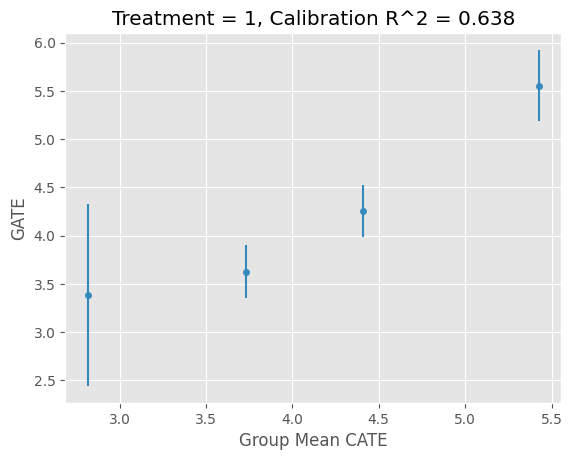

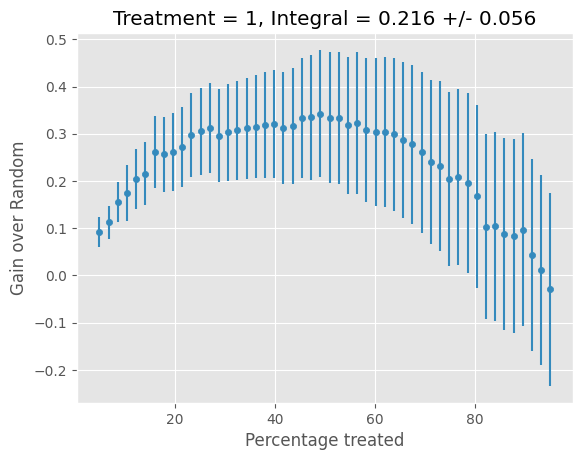

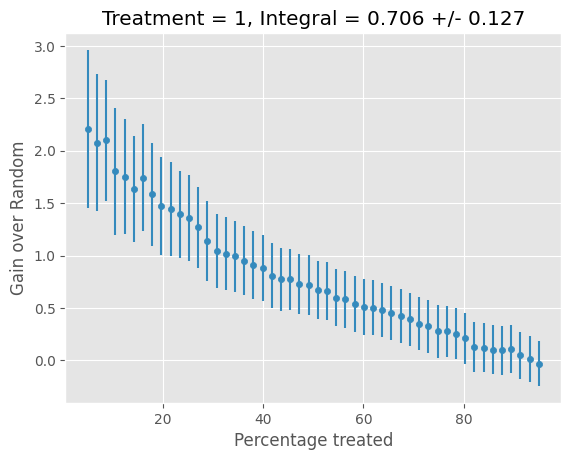

In [11]:
validation_results = caml.validate(n_groups=4,n_bootstrap=1000,print_full_report=True)

#### Refit best estimator on full dataset

In [12]:
caml.fit_final()

In [13]:
caml.final_estimator

[12/10/24 11:56:55] INFO     The final estimator has been fit on the entire dataset and will be         ]8;id=359209;file:///home/jadmin/projects/caml/caml/core/_base.py\_base.py]8;;\:]8;id=529306;file:///home/jadmin/projects/caml/caml/core/_base.py#73\73]8;;\
                             returned.                                                                             

#### Predict CATEs

In [14]:
## "Out of sample" predictions

cate_predictions = caml.predict()

cate_predictions

array([5.53698974, 6.17270743, 3.65614233, ..., 4.05019704, 4.40357249,
       3.5407998 ])

#### CATE Visualization/Summary

In [15]:
cate_summary = caml.summarize()

cate_summary

,cate_predictions_0_1
count,5000.000000
mean,4.079844
std,0.954062
min,0.663294
25%,3.431781
50%,4.065563
75%,4.705440
max,7.376048


In [16]:
true_ate

4.014409054811685

#### Access my dataframe, estimator object, and get string representation of class

In [18]:
caml.df

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,y,d,true_cates,uuid
0,1.487341,1.237681,0.340515,0.954684,1.110521,0.917506,-0.258253,-1.025726,-0.504681,-1.449941,4.004137,1.0,5.586296,0
1,2.263414,0.785488,-0.035789,-0.420643,0.191336,-0.383101,-0.700961,0.277199,0.691194,2.025799,4.623563,1.0,6.018083,1
2,-0.186643,0.503127,-0.678428,-1.891030,0.411495,-0.740817,-1.167659,-0.439297,-0.135027,-1.702567,-0.690945,0.0,3.745868,2
3,-0.614268,0.685133,0.515181,0.500385,0.777315,1.596222,1.179861,1.937306,-0.002442,0.134798,0.789065,0.0,3.815659,3
4,0.187142,-0.409850,-0.743009,0.210428,1.152676,-0.670240,-1.290981,-0.777656,-1.201572,-1.319242,0.707379,0.0,3.980391,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.202108,0.769520,0.210571,0.761491,0.507551,-0.363243,-0.271814,0.071516,1.633065,0.290216,3.879683,1.0,4.407952,4995
4996,-0.769191,-1.448448,-0.011607,0.387138,0.409056,0.084060,0.974782,1.094457,1.236400,0.757163,0.800700,0.0,3.150076,4996
4997,-0.140078,0.653867,0.143004,-0.486888,-0.851383,-0.717253,-0.741155,0.272758,1.284163,1.017715,4.324480,1.0,3.975271,4997
4998,0.512572,-1.360082,0.218130,0.998439,-0.212205,0.592543,0.117937,0.136803,0.893474,-0.014921,4.966744,1.0,4.233212,4998


In [19]:
from econml.score import EnsembleCateEstimator

# Use this estimator object as pickled object for optimized inference
final_estimator = caml.final_estimator

if isinstance(final_estimator, EnsembleCateEstimator):
    for model in final_estimator._cate_models:
        print(model)
        print(model._input_names)
else:
    print(final_estimator)
    print(final_estimator._input_names)

[12/10/24 11:57:11] INFO     The final estimator has been fit on the entire dataset and will be         ]8;id=899888;file:///home/jadmin/projects/caml/caml/core/_base.py\_base.py]8;;\:]8;id=67770;file:///home/jadmin/projects/caml/caml/core/_base.py#73\73]8;;\
                             returned.                                                                             

{'feature_names': ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9'], 'output_names': ['Y0'], 'treatment_names': ['T0_1.0']}
{'feature_names': ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9'], 'output_names': ['Y0'], 'treatment_names': ['T0_1.0']}
{'feature_names': ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9'], 'output_names': ['Y0'], 'treatment_names': ['T0_1.0']}


In [20]:
print(caml)

================== CamlCATE Object ==================
Data Backend: pandas
No. of Observations: 5000
Outcome Variable: y
Discrete Outcome: False
Treatment Variable: d
Discrete Treatment: True
Features/Confounders for Heterogeneity (X): ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10']
Features/Confounders as Controls (W): []
Random Seed: 0
Nuissance Model Y_X: ExtraTreesRegressor(max_features=0.9697892695704531, max_leaf_nodes=110,
                    n_estimators=152, n_jobs=-1, random_state=12032022)
Propensity/Nuissance Model T_X: XGBClassifier(base_score=None, booster=None, callbacks=[],
              colsample_bylevel=0.8460313284002319, colsample_bynode=None,
              colsample_bytree=0.9379679745175314, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate

In [22]:
df

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,y,d,true_cates,uuid
0,1.487341,1.237681,0.340515,0.954684,1.110521,0.917506,-0.258253,-1.025726,-0.504681,-1.449941,4.004137,1.0,5.586296,0
1,2.263414,0.785488,-0.035789,-0.420643,0.191336,-0.383101,-0.700961,0.277199,0.691194,2.025799,4.623563,1.0,6.018083,1
2,-0.186643,0.503127,-0.678428,-1.891030,0.411495,-0.740817,-1.167659,-0.439297,-0.135027,-1.702567,-0.690945,0.0,3.745868,2
3,-0.614268,0.685133,0.515181,0.500385,0.777315,1.596222,1.179861,1.937306,-0.002442,0.134798,0.789065,0.0,3.815659,3
4,0.187142,-0.409850,-0.743009,0.210428,1.152676,-0.670240,-1.290981,-0.777656,-1.201572,-1.319242,0.707379,0.0,3.980391,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.202108,0.769520,0.210571,0.761491,0.507551,-0.363243,-0.271814,0.071516,1.633065,0.290216,3.879683,1.0,4.407952,4995
4996,-0.769191,-1.448448,-0.011607,0.387138,0.409056,0.084060,0.974782,1.094457,1.236400,0.757163,0.800700,0.0,3.150076,4996
4997,-0.140078,0.653867,0.143004,-0.486888,-0.851383,-0.717253,-0.741155,0.272758,1.284163,1.017715,4.324480,1.0,3.975271,4997
4998,0.512572,-1.360082,0.218130,0.998439,-0.212205,0.592543,0.117937,0.136803,0.893474,-0.014921,4.966744,1.0,4.233212,4998


# Plots

In [24]:
from caml.extensions.plots import (cate_histogram_plot, 
                                   cate_true_vs_estimated_plot, 
                                   cate_line_plot)

df['cate_predictions'] = cate_predictions

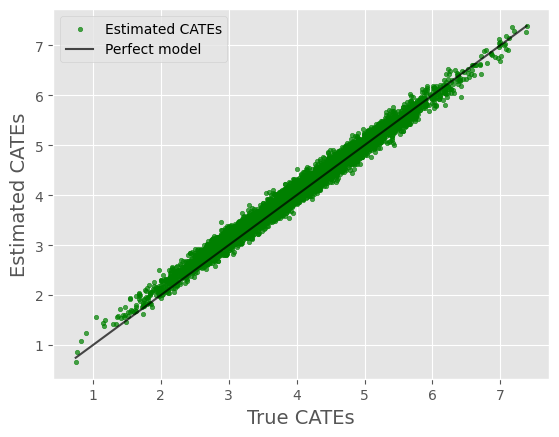

In [25]:
cate_true_vs_estimated_plot(true_cates=df['true_cates'],estimated_cates=df['cate_predictions'])

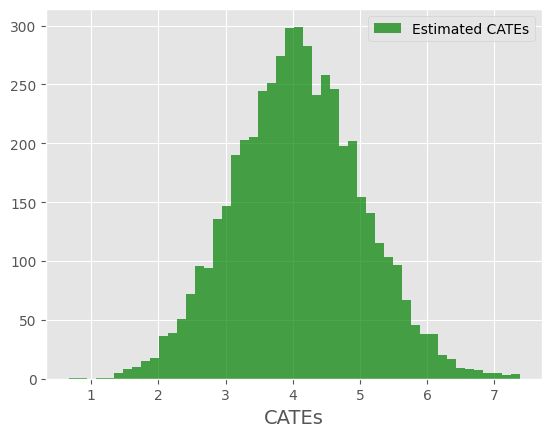

In [26]:
cate_histogram_plot(estimated_cates=df['cate_predictions'])

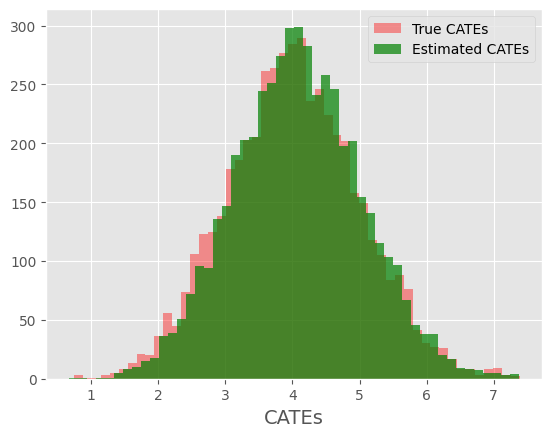

In [27]:
cate_histogram_plot(estimated_cates=df['cate_predictions'],true_cates=df['true_cates'])

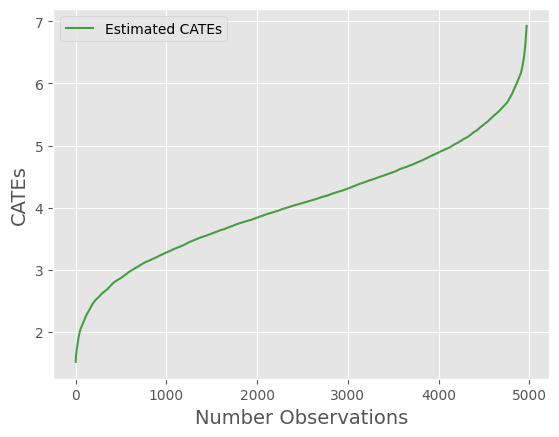

In [28]:
cate_line_plot(estimated_cates=df['cate_predictions'],window=30)

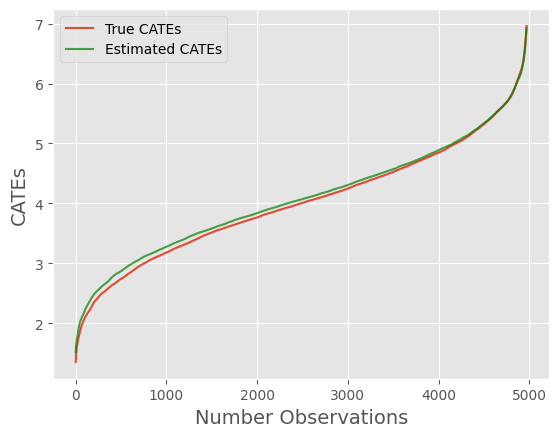

In [29]:
cate_line_plot(estimated_cates=df['cate_predictions'],true_cates=df['true_cates'],window=30)